In [1]:
import pandas as pd ## Обновить pandas до последней версии
import numpy as np
import math
import os
import glob
import mysql.connector
import datetime
from mysql.connector import errorcode
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


import warnings
warnings.filterwarnings("ignore")

#### Переменные, которые можно задать далее по скрипту (в коде ниже ещё раз будут поля)

In [2]:
risk_horizon = 19 #Горизонт риска, в месяцах с начала заключения контракта
threshold_age = 47.0 #Порог для отсечения о дефолте на основании возраста (взят как медиана)
threshold_income = 135000.0 #Порог для отсечения о дефолте на основании дохода (взят как медиана)
cat_var = 'marital_status_num' #Выбор категориальной переменной для построения графика WOE

## 1) Передаём таблицу платежей в БД

In [3]:
payments_table = pd.read_excel('payments.xls')

###### Передаём в БД таблицу по платежам

In [4]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE IF NOT EXISTS payments 
(id INT NOT NULL UNIQUE,
contract_number INT, 
date DATE, 
amount_due INT,
amount_paid INT, 
PRIMARY KEY (id))""")

cnx.commit()

In [5]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

for i in range(0, payments_table.shape[0]):
    cursor.execute(""" INSERT INTO payments 
    VALUES 
    (%d, %d, '%s', %d, %d)""" % (
        i,
        payments_table['Contract Number'][i],
        payments_table['Date'][i],
        payments_table['Amount Due'][i], 
        payments_table['Amount Paid'][i] 
        ))

cnx.commit()

## З) а

###### Выгружаем из БД таблицу по платежам

In [4]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

payments_table = pd.read_sql_query("SELECT * FROM payments", cnx)
payments_table.keys()

Index(['id', 'contract_number', 'date', 'amount_due', 'amount_paid'], dtype='object')

###### Получаем дату дефолта по контракту, возвращая дату, если дефолт был, и 0000-00-00, если нет 

In [7]:
def get_90_day_default(contract_number):
    table = payments_table[payments_table['contract_number'] == contract_number]## Выбираем строки с конкретным номером контракта
    table = table.reset_index() #обнуляем индексы, чтобы при дальнейшей итерации всё работало с 0
    for i in  range(0, len(table['amount_paid'])):
        try:
            if (table['amount_paid'][i] < table['amount_due'][i] and table['amount_paid'][i+1] < table['amount_due'][i+1] and
                table['amount_paid'][i+2] < table['amount_due'][i+2] and table['amount_paid'][i+3] < table['amount_due'][i+3]):
                #Проверяем чтобы заёмщик не платил 4 даты подряд
                date_90 = table['date'][i + 3] #фиксируем дату просрочки
                date_90 = (str(pd.to_datetime(date_90).year) + '-' + str(pd.to_datetime(date_90).month) + 
                           '-' + str(pd.to_datetime(date_90).day)) #переводим в нужный формат
                break
                
            else:
                date_90 = '0000-00-00' #если нет просрочки то передаём такую дату
        except:
            True
    return date_90

###### Получаем список дефолтов по всем контрактам

In [8]:
data = []
for i in payments_table['contract_number'].unique():
    data.append((i, get_90_day_default(i)))
data[0:5] 

[(100875, '2017-3-5'),
 (100524, '0000-00-00'),
 (100552, '0000-00-00'),
 (100493, '0000-00-00'),
 (100797, '0000-00-00')]

###### Обновляем таблицу контрактов, отправляя информацию о просрочках 90+

In [9]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

cursor.execute("""ALTER TABLE contracts ADD date_of_90_day_default DATE NULL""")

for i in data:
    cursor.execute("""UPDATE contracts SET date_of_90_day_default = '%s' WHERE contract_number = %d """ %(i[1], i[0]))

#'0000-00-00' Означает что нет просрочки

cnx.commit()
cnx.close()

## b, с) Задание горизонта риска + дефолт/недефолт на выбранном горизонте

###### Получаем дату дефолта на заданном горизонте риска

In [8]:
def get_default_with_horizon_risk(contract_number, risk_horizon):
    table = payments_table[payments_table['contract_number'] == contract_number]
    if len(table) >= risk_horizon:
        table = table[:risk_horizon] #функция аналогична просрочке 90+, просто выбираем нужное количество строк как :risk_horizon 
        table = table.reset_index()
        summa1 = 0
        for i in  range(0, len(table['amount_paid'])):
            try:
                if (table['amount_paid'][i] < table['amount_due'][i] and table['amount_paid'][i+1] < table['amount_due'][i+1] and
                table['amount_paid'][i+2] < table['amount_due'][i+2] and table['amount_paid'][i+3] < table['amount_due'][i+3]):
                    date_90 = table['date'][i + 3]
                    date_90 = (str(pd.to_datetime(date_90).year) + '-' + str(pd.to_datetime(date_90).month) + 
                               '-' + str(pd.to_datetime(date_90).day))
                    break

                else:
                    date_90 = '0000-00-00'
            except:
                True
    else:
        date_90 = 'срок кредита меньше горизонта риска'
    return date_90

###### Создаём список: номер контракта, дата дефолта (если его не было то 0000-00-00 и флаг 0/1)

In [9]:
data_with_risk_horizon = []
for i in payments_table['contract_number'].unique():
    if get_default_with_horizon_risk(i, risk_horizon) != 'срок кредита меньше горизонта риска':
        if get_default_with_horizon_risk(i, risk_horizon) == '0000-00-00':
            data_with_risk_horizon.append((i, get_default_with_horizon_risk(i, risk_horizon), 0))
        else:
            data_with_risk_horizon.append((i, get_default_with_horizon_risk(i, risk_horizon), 1))

In [10]:
print(len(data_with_risk_horizon))
data_with_risk_horizon[0:5]

43


[(100524, '0000-00-00', 0),
 (100552, '0000-00-00', 0),
 (100797, '0000-00-00', 0),
 (100929, '0000-00-00', 0),
 (100022, '0000-00-00', 0)]

##### Отправляем в БД с информацию о флагах дефолт/недефолт с кредитам не меньше горизонта риска

Сначала по номеру контракта

In [13]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE IF NOT EXISTS contracts_risk_horizon_{0}_months 
(contract_number INT, 
bankruptcy BOOLEAN, 
date_of_default DATE)""".format(risk_horizon))

cnx.commit()
cnx.close()

In [14]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

for i in data_with_risk_horizon:
    cursor.execute("""INSERT INTO contracts_risk_horizon_{0}_months 
    VALUES
    (%d, %d, '%s')""".format(risk_horizon) % (
    i[0],
    i[2],
    i[1]))
    
cnx.commit()
cnx.close()

##### Отправляем в БД таблицу id - флаг дефолт/недефолт на заданном горизонте риска (пункт f)

In [15]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE borrowers_default_with_risk_horizon_{0}_months AS (select A.id, bankruptcy, date_of_default
FROM
(SELECT bankruptcy, id, date_of_default
FROM contracts
INNER JOIN contracts_risk_horizon_{1}_months ON
contracts.contract_number = contracts_risk_horizon_{2}_months.contract_number) AS A
INNER JOIN applications1 ON
applications1.id = A.id)""".format(risk_horizon, risk_horizon, risk_horizon))

cnx.commit()
cnx.close()

## e) WOE, IV, ROC - кривая

In [16]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

applications_df = pd.read_sql_query("SELECT * FROM applications1", cnx)
applications_df.keys()

Index(['id', 'issue_date', 'children', 'family', 'age', 'gender', 'income',
       'age_of_car', 'application_date', 'marital_status_num',
       'employed_by_num', 'education_num', 'position_num', 'income_type_num',
       'housing_num', 'house_ownership_num'],
      dtype='object')

##### Выберем все возможные категориальные переменные

In [17]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

applications_with_risk_horizon = pd.read_sql_query("""SELECT bankruptcy, children, family, gender, marital_status_num,
employed_by_num, education_num, position_num, income_type_num, housing_num, house_ownership_num FROM
(SELECT bankruptcy, id
FROM contracts
INNER JOIN contracts_risk_horizon_{0}_months ON
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) AS A
INNER JOIN applications1 ON
applications1.id = A.id""".format(risk_horizon, risk_horizon), cnx)

In [18]:
applications_with_risk_horizon.head(5)

,bankruptcy,children,family,gender,marital_status_num,employed_by_num,education_num,position_num,income_type_num,housing_num,house_ownership_num
0,0,0,2,1,1,14,0,3,3,0,0
1,0,0,1,0,4,5,3,5,4,0,2
2,0,0,1,0,4,13,3,3,4,0,2
3,0,0,2,0,1,12,3,5,3,0,2
4,0,1,3,1,1,1,0,0,0,0,2


###### Функция которая строит полную таблицу для WOE и IV для категорильных (взята с https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)

In [19]:
max_bin = 20
force_bin = 4

# define a binning function
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def woe_iv_categorical(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            conv = char_bin(target, df1[i])
            conv["VAR_NAME"] = i
            count = count + 1
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [20]:
woe_and_iv_categorical = woe_iv_categorical(applications_with_risk_horizon, applications_with_risk_horizon.bankruptcy)[0]
woe_and_iv_categorical

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,children,0,0,32,2,0.062500,30,0.937500,1.0,0.731707,0.312375,0.083808
1,children,1,1,10,0,0.000000,10,1.000000,0.0,0.243902,0.000000,0.083808
2,children,2,2,1,0,0.000000,1,1.000000,0.0,0.024390,0.000000,0.083808
3,family,1,1,10,1,0.100000,9,0.900000,0.5,0.219512,0.823200,0.237914
4,family,2,2,24,1,0.041667,23,0.958333,0.5,0.560976,-0.115069,0.237914
5,family,3,3,8,0,0.000000,8,1.000000,0.0,0.195122,0.000000,0.237914
6,family,4,4,1,0,0.000000,1,1.000000,0.0,0.024390,0.000000,0.237914
7,gender,0,0,20,1,0.050000,19,0.950000,0.5,0.463415,0.075986,0.005364
8,gender,1,1,23,1,0.043478,22,0.956522,0.5,0.536585,-0.070618,0.005364
9,marital_status_num,0,0,4,0,0.000000,4,1.000000,0.0,0.097561,0.000000,1.081996


##### Предлагаем пользователю выбрать отдельную любую переменную для построения графика

In [21]:
cat_var = 'marital_status_num'

In [22]:
df_cat_var = woe_and_iv_categorical[woe_and_iv_categorical['VAR_NAME'] == cat_var]
df_cat_var

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
9,marital_status_num,0,0,4,0,0.000000,4,1.000000,0.0,0.097561,0.000000,1.081996
10,marital_status_num,1,1,27,1,0.037037,26,0.962963,0.5,0.634146,-0.237672,1.081996
11,marital_status_num,3,3,1,0,0.000000,1,1.000000,0.0,0.024390,0.000000,1.081996
12,marital_status_num,4,4,8,0,0.000000,8,1.000000,0.0,0.195122,0.000000,1.081996
13,marital_status_num,5,5,3,1,0.333333,2,0.666667,0.5,0.048780,2.327278,1.081996


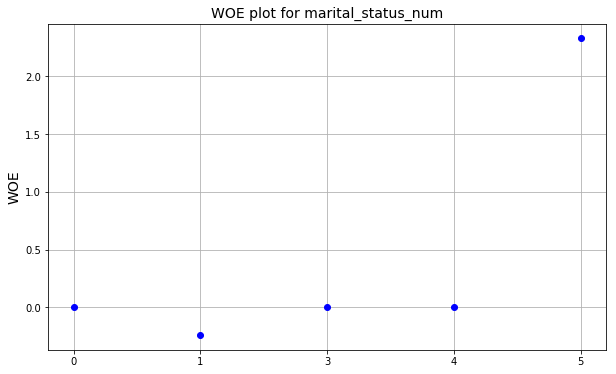

In [23]:
%matplotlib inline 

plt.figure(figsize=(10, 6));
plt.plot(list(range(df_cat_var.shape[0])), df_cat_var.WOE, 'bo')
plt.grid()
plt.xticks(list(range(df_cat_var.shape[0])), df_cat_var.MIN_VALUE)
plt.ylabel("WOE", fontsize=14)

plt.title("WOE plot for {0}".format(cat_var), fontsize=14)
plt.show()

In [24]:
cat_var1 = cat_var[:-4] #Все ключи в словарях заканчиваются на _num, чтобы вытащить их достаточно отбросить последние 4 буквы

In [25]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

keys = pd.read_sql_query("""SELECT * FROM dict_keys_applications WHERE characteristic = '{0}' """.format(cat_var1), cnx)
keys ##напомним ключ

,characteristic,key_num,id_number
0,marital_status,Married,1
1,marital_status,Single / not married,4
2,marital_status,Civil marriage,0
3,marital_status,Widow,5
4,marital_status,Separated,3
5,marital_status,NULL,2


##### Отдельно IV

In [26]:
iv_categorical = woe_and_iv_categorical[['VAR_NAME', 'IV']].drop_duplicates().copy()
iv_categorical = iv_categorical.reset_index()
iv_categorical = iv_categorical.drop(['index'], axis = 1)
iv_categorical

,VAR_NAME,IV
0,children,0.083808
1,family,0.237914
2,gender,0.005364
3,marital_status_num,1.081996
4,employed_by_num,1.871072
5,education_num,0.166637
6,position_num,0.230898
7,income_type_num,0.288489
8,housing_num,0.005560
9,house_ownership_num,0.054403


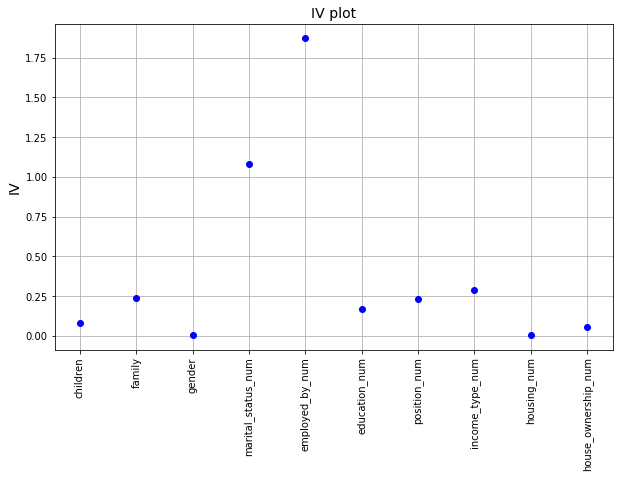

In [27]:
plt.figure(figsize=(10, 6));
plt.plot(list(range(iv_categorical.shape[0])), iv_categorical.IV, 'bo')
plt.grid()
plt.xticks(list(range(iv_categorical.shape[0])), iv_categorical.VAR_NAME, rotation='vertical')
plt.ylabel("IV", fontsize=14)

plt.title("IV plot", fontsize=14)
plt.show()

###### Отдельно квантилизируем непрерывные переменные

In [28]:
applications_df.keys()

Index(['id', 'issue_date', 'children', 'family', 'age', 'gender', 'income',
       'age_of_car', 'application_date', 'marital_status_num',
       'employed_by_num', 'education_num', 'position_num', 'income_type_num',
       'housing_num', 'house_ownership_num'],
      dtype='object')

In [29]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

applications_with_risk_horizon = pd.read_sql_query("""SELECT bankruptcy, age, income, age_of_car FROM
(SELECT bankruptcy, id
FROM contracts
INNER JOIN contracts_risk_horizon_{0}_months on
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) AS A
INNER JOIN applications1 ON
applications1.id = A.id""".format(risk_horizon, risk_horizon), cnx)

cnx.close()
applications_with_risk_horizon.head(5)

,bankruptcy,age,income,age_of_car
0,0,50,270000.0,NaN
1,0,54,67500.0,26.0
2,0,55,121500.0,NaN
3,0,50,99000.0,NaN
4,0,40,171000.0,17.0


*Разбиение реализуется таким образом, чтобы оно устанавливало монотонную зависимость (прямую или обратную) между зависимой и независимой переменной*

In [30]:
max_bin = 15 ## Можно установить большее число максимальных разбиений
force_bin = 3 ##Минимальное число разбиений

In [31]:
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)


def woe_iv_cont(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [32]:
woe_and_iv_cont = woe_iv_cont(applications_with_risk_horizon, applications_with_risk_horizon.bankruptcy)[0]
woe_and_iv_cont = woe_and_iv_cont.dropna()
woe_and_iv_cont

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,21.0,27.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
1,age,29.0,32.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
2,age,33.0,34.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
3,age,35.0,37.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
4,age,39.0,40.0,5,0.0,0.000000,5.0,1.000000,0.0,0.121951,0.000000,2.486657
6,age,41.0,46.0,4,0.0,0.000000,4.0,1.000000,0.0,0.097561,0.000000,2.486657
7,age,47.0,50.0,5,0.0,0.000000,5.0,1.000000,0.0,0.121951,0.000000,2.486657
9,age,51.0,52.0,3,1.0,0.333333,2.0,0.666667,0.5,0.048780,2.327278,2.486657
10,age,53.0,53.0,2,1.0,0.500000,1.0,0.500000,0.5,0.024390,3.020425,2.486657
11,age,54.0,55.0,4,0.0,0.000000,4.0,1.000000,0.0,0.097561,0.000000,2.486657


In [33]:
iv_cont = woe_and_iv_cont[['VAR_NAME', 'IV']].drop_duplicates().copy()
iv_cont = iv_cont.reset_index()
iv_cont = iv_cont.drop(['index'], axis = 1)
iv_cont

,VAR_NAME,IV
0,age,2.486657
1,income,1.092166
2,age_of_car,0.877319


### ROC-Curve

In [34]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw1_db', user = 'hw1_user')
cursor = cnx.cursor()

default_for_cont = pd.read_sql_query("""select bankruptcy, age, income from
(select bankruptcy, id
from contracts
inner join contracts_risk_horizon_{0}_months on
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) as A
inner join applications1 on
applications1.id = A.id""".format(risk_horizon, risk_horizon), cnx)

cnx.close()
default_for_cont.head(5)

,bankruptcy,age,income
0,0,50,270000.0
1,0,54,67500.0
2,0,55,121500.0
3,0,50,99000.0
4,0,40,171000.0


In [35]:
print(' медиана для age =', default_for_cont.age.median(),'\n',
      'медиана для income =', default_for_cont.income.median())

 медиана для age = 47.0 
 медиана для income = 135000.0


In [36]:
threshold_age = 47.0 #зададим порог как медианные значения
threshold_income = 135000.0

In [37]:
default_for_cont['bankruptcy_age'] = [1 if x  > 47 else 0 for x in default_for_cont['age']]
default_for_cont['income_age'] = [1 if x  > 135000 else 0 for x in default_for_cont['income']]

In [38]:
fpr, tpr, threshold = metrics.roc_curve(default_for_cont.bankruptcy, default_for_cont.bankruptcy_age)
roc_auc = metrics.auc(fpr, tpr)
gini = roc_auc * 2 - 1

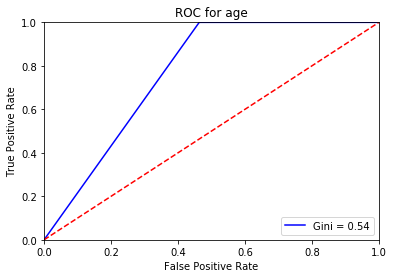

In [39]:
plt.title('ROC for age')
plt.plot(fpr, tpr, 'b', label = 'Gini = %0.2f' % gini)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
fpr, tpr, threshold = metrics.roc_curve(default_for_cont.bankruptcy, default_for_cont.income_age)
roc_auc = metrics.auc(fpr, tpr)
gini = roc_auc * 2 - 1

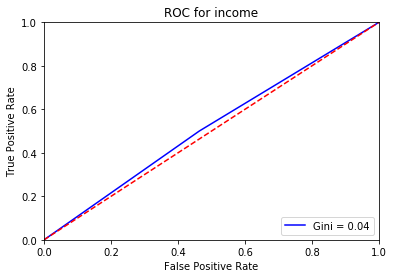

In [41]:
plt.title('ROC for income')
plt.plot(fpr, tpr, 'b', label = 'Gini = %0.2f' % gini)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()